In [307]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
import matplotlib.pyplot as plt
from packages.utils import plot_kfold


# Dataset import and cleaning

In [308]:
df = pd.read_csv('data/Auto.csv')
# df = pd.read_csv('https://github.com/vincenzorrei/EDU-Datasets/raw/refs/heads/main/Auto.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


The horsepower column is currently of type object, indicating that its data contains non-numeric values (e.g., strings or possibly missing/invalid entries). Since horsepower represents a numerical feature, it should ideally be converted to a numeric data type (float or int) for meaningful analysis or modeling.


In [309]:
# Find non-numeric values in the 'horsepower' column

# pd.to_numeric(errors='coerce'):
# Converts the column values to numeric, replacing those that cannot be converted with NaN.
nan_index = pd.to_numeric(df['horsepower'], errors='coerce').isna()

# Get the non-numeric values
non_numeric_values = df['horsepower'][nan_index]
print(non_numeric_values.value_counts())

horsepower
?    5
Name: count, dtype: int64


The presence of the value ? in your horsepower column is likely due to one of the following reasons:

- Data Entry Issues:
In the source data, ? might have been used as a placeholder for missing or unknown values instead of leaving the field blank or using a standard missing value indicator like NaN.

- Formatting in the Dataset:
If the data was extracted from a text file (e.g., CSV, TSV), ? might have been used as a way to indicate incomplete or invalid entries.

- Original Dataset Conventions:
In some older datasets, especially in UCI repositories or similar, ? is commonly used to signify "unknown" or "not applicable."

In [310]:
# Replace problematic values like '?' with NaN
df['horsepower'] = df['horsepower'].replace('?', np.nan)

# Convert 'horsepower' to numeric (non-numeric values become NaN)
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Drop rows where 'horsepower' is NaN
df.dropna(subset=['horsepower'], inplace=True)

print(df.isna().sum())


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


In [311]:
# Create polynomial features
max_polynomial_degree = 10

for i in range(2, max_polynomial_degree+1):
    df[f'horsepower^{i}'] = df['horsepower'] ** i


## Select X and y

In [312]:
# Store the column names of the horsepower columns
horsepower_cols = [i for i in df.columns if 'horsepower' in i]

# Split the data into X and y
X = df[horsepower_cols]
y = df['mpg']

X

,horsepower,horsepower^2,horsepower^3,horsepower^4,horsepower^5,horsepower^6,horsepower^7,horsepower^8,horsepower^9,horsepower^10
0,130.0,16900.0,2197000.0,285610000.0,3.712930e+10,4.826809e+12,6.274852e+14,8.157307e+16,1.060450e+19,1.378585e+21
1,165.0,27225.0,4492125.0,741200625.0,1.222981e+11,2.017919e+13,3.329566e+15,5.493784e+17,9.064743e+19,1.495683e+22
2,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
3,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
4,140.0,19600.0,2744000.0,384160000.0,5.378240e+10,7.529536e+12,1.054135e+15,1.475789e+17,2.066105e+19,2.892547e+21
...,...,...,...,...,...,...,...,...,...,...
392,86.0,7396.0,636056.0,54700816.0,4.704270e+09,4.045672e+11,3.479278e+13,2.992179e+15,2.573274e+17,2.213016e+19
393,52.0,2704.0,140608.0,7311616.0,3.802040e+08,1.977061e+10,1.028072e+12,5.345973e+13,2.779906e+15,1.445551e+17
394,84.0,7056.0,592704.0,49787136.0,4.182119e+09,3.512980e+11,2.950903e+13,2.478759e+15,2.082157e+17,1.749012e+19
395,79.0,6241.0,493039.0,38950081.0,3.077056e+09,2.430875e+11,1.920391e+13,1.517109e+15,1.198516e+17,9.468276e+18


# Train & Test split

In [313]:
t_prop = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_prop, random_state=42)

# 1. Validation Set Approach

The validation approach in data science and machine learning is a method for assessing the performance of a model on unseen data.

Its primary purpose is to ensure that the model generalizes well to new, unseen datasets. This approach involves splitting the available data into different sets (usually 50% vs- 50%) and evaluating the model using these subsets

In [314]:
# Dividing the dataset into training and val sets using cross-validation
prop = 0.5
X_train_cross, X_val, y_train_cross, y_val = train_test_split(X_train, y_train, test_size=prop, random_state=42)


In [315]:
# Choose the model
model = LinearRegression()
results = {}

# Create a loop
for i in range(1, len(horsepower_cols)+1):

    # Fit the model
    model.fit(X_train_cross[horsepower_cols[:i]], y_train_cross)
    # Predict the target variable
    y_val_pred = model.predict(X_val[horsepower_cols[:i]])
    # Calculate the MSE
    mse = mean_squared_error(y_val, y_val_pred)
    results[horsepower_cols[i-1]] = mse
    print(f'MSE for polynomial degree {i}: {mse:.4f}')


MSE for polynomial degree 1: 27.1455
MSE for polynomial degree 2: 18.9966
MSE for polynomial degree 3: 18.8192
MSE for polynomial degree 4: 19.2458
MSE for polynomial degree 5: 18.4018
MSE for polynomial degree 6: 18.4019
MSE for polynomial degree 7: 18.4469
MSE for polynomial degree 8: 18.6153
MSE for polynomial degree 9: 18.5858
MSE for polynomial degree 10: 18.5264


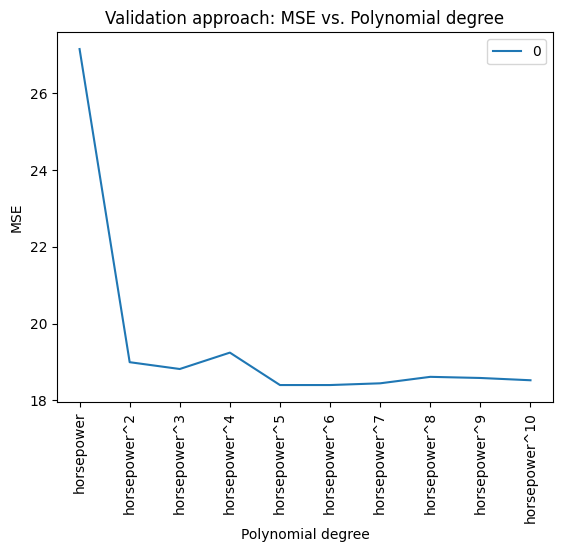

In [316]:
# Plot the results
results = pd.DataFrame([results])
results.T.plot()
plt.xlabel('Polynomial degree')
plt.xticks(ticks=range(len(results.columns)), labels=results.columns, rotation=90)
plt.ylabel('MSE')
plt.title('Validation approach: MSE vs. Polynomial degree')
plt.show()


# 2. K-Fold Cross Validation


The choice of the optimal number of 
𝑘
k in k-fold cross-validation is a trade-off between the accuracy of the model performance estimate and computational cost. Typically, a 
𝑘
k between 5 and 10 is used

##### (Optional) What's inside k-fold? Shuffle?

In [317]:
# Example for Just horsepower

# Initialize the model and k-fold cross-validation
k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
model = LinearRegression()

# List to store MSE for each fold
mse_scores = []
X_train_single = X_train['horsepower']

# Perform k-fold cross-validation
for i, (train_index, val_index) in enumerate(kf.split(X_train_single)):
    # Split the data into training and test sets
    X_train_cross, X_val = X_train_single.iloc[train_index], X_train_single.iloc[val_index]
    y_train_cross, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Select only horsepower column
    X_train_cross = X_train_cross.values.reshape(-1, 1)
    
    # Train the model on the training set
    model.fit(X_train_cross, y_train_cross)
    
    # Predict on the test set
    y_pred = model.predict(X_val.values.reshape(-1, 1))
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val.values, y_pred)
    mse_scores.append(mse)
    # print(f"Fold {i}:")
    #print(f"  Training dataset index: {train_index}")
    print(f"\nTest dataset index: {val_index}")
    print(f"Mean MSE across {1} folds: {mse:.4f}")

# Calculate the mean and standard deviation of MSE
mean_mse = np.mean(mse_scores)

# Output the results
print(f"{'-'*30}\nMean MSE across {k} folds: {mean_mse:.4f}")


Test dataset index: [  9  15  16  18  55  60  69  73  75 113 114 115 139 145 154 156 161 169
 185 187]
Mean MSE across 1 folds: 40.8943

Test dataset index: [ 19  24  30  45  56  67  68  76  82  85  93  95 112 119 122 128 137 138
 173 183]
Mean MSE across 1 folds: 18.6786

Test dataset index: [  5  12  29  35  42  51  65  66  78  97 118 123 124 132 135 136 162 165
 168 170]
Mean MSE across 1 folds: 16.9677

Test dataset index: [  2  22  26  31  36  38  41  46  96 101 104 144 146 148 158 159 166 182
 186 191]
Mean MSE across 1 folds: 24.0837

Test dataset index: [  0   4   6  10  11  27  32  33  62  90  98 100 109 125 127 140 141 142
 155 193]
Mean MSE across 1 folds: 32.0052

Test dataset index: [ 23  25  28  40  44  64  70  79  81  84 108 111 117 126 143 147 152 175
 178 180]
Mean MSE across 1 folds: 14.4604

Test dataset index: [  3  39  43  47  53  61  77  86  94 105 120 133 150 153 164 174 176 181
 190]
Mean MSE across 1 folds: 35.9518

Test dataset index: [  7   8  13  17  34  49

#### How to K-Fold Cross validation

In [318]:
# Create the scorer for Mean Squared Error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize the linear regression model
log_reg = LinearRegression()

# Create the K-Fold cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation measuring the Mean Squared Error
scores = cross_val_score(
    log_reg, X_train, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1
) # you can simply use scoring='accuracy' instead of mse_scorer in classification problems

# Calculate the mean of the MSE scores
mean_mse = -scores.mean()  # Invert the sign because greater_is_better=False
print(f"Mean Squared Error (average): {mean_mse}")


Mean Squared Error (average): 16.7273842946942


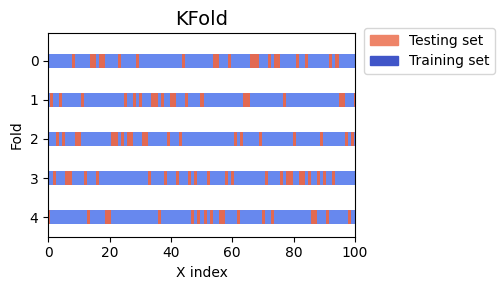

In [319]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))
plot_kfold(cv, X_train, y_train, ax, 5)
plt.tight_layout()
fig.subplots_adjust(right=0.6)

# 3. Leave One Out Cross Validation (LOOCV)

In [320]:
# Create the LOOCV cross-validator
cv = LeaveOneOut()

# Perform cross-validation measuring the Mean Squared Error
scores = cross_val_score(
    log_reg, X_train, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1
) # you can simply use scoring='accuracy' instead of mse_scorer in classification problems

# Calculate the mean of the MSE scores
mean_mse = -scores.mean()  # Invert the sign because greater_is_better=False
print(f"Mean Squared Error (average): {mean_mse}")


Mean Squared Error (average): 17.15630622984947
